<a href="https://colab.research.google.com/github/hamzafarooq/multi-agent-course/blob/main/Module_5/Agents/Agent%20Pro%20ReAct.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
!pip install openai youtube_transcript_api duckduckgo-search requests python-pptx --quiet

In [10]:
from openai import OpenAI
import subprocess
import tempfile
import re
import importlib
import sys
import os
from urllib.parse import urlparse, parse_qs
import json

In [11]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TRAVERSAAL_ARES_API_KEY"] = userdata.get('ARES_API_KEY')

## Tool Base Class

In [12]:
from typing import Any
from abc import ABC, abstractmethod
from pydantic import BaseModel, ConfigDict


class Tool(ABC, BaseModel):
  name: str
  description: str
  arg: str

  def model_post_init(self, __context: Any) -> None:
    self.name = self.name.lower().replace(' ', '_')
    self.description = self.description.lower()
    self.arg = self.arg.lower()

  @abstractmethod
  def run(self, prompt: str) -> str:
    pass

  def get_tool_description(self):
    return f"Tool: {self.name}\nDescription: {self.description}\nArg: {self.arg}\n"

class LLMTool(Tool):
  client: Any = OpenAI(api_key=os.environ["OPENAI_API_KEY"])

## Ares Internet Search Tool

In [13]:
import requests
from pydantic import HttpUrl

class AresInternetTool(Tool):
  name: str = "Ares Internet Search Tool"
  description: str = "Tool to search real-time relevant content from the internet"
  arg: str = "A single string parameter that will be searched on the internet to find relevant content"

  # Specific Parameters
  url : HttpUrl = "https://api-ares.traversaal.ai/live/predict"
  x_api_key: str = os.environ["TRAVERSAAL_ARES_API_KEY"]

  def run(self, prompt: str) -> str:
    print(f"Calling Ares Internet Search Tool with prompt: {prompt}")
    payload = {"query": prompt}
    response = requests.post(self.url, json=payload, headers={
        "x-api-key": self.x_api_key,
        "content-type": "application/json"
    })
    if response.status_code != 200:
        return f"Error: {response.status_code} - {response.text}"
    response = response.json()
    return response['data']['response_text']

## Code Engine Tool

In [14]:
class CodeEngine(LLMTool):

  name: str = "Code Generation and Execution Tool"
  description: str = "A coding tool that can take a prompt and generate executable Python code. It parses and executes the code. Returns the code and the error if the code execution fails."
  arg: str = "A single string parameter describing the coding task."

  def parse_and_exec_code(self, response: str):
    result = re.search(r'```python\s*([\s\S]*?)\s*```', response)
    code_string = result.group(1)
    if "pip install" in code_string.split("\n")[0]:
      print("Requires PIP package installations")
      packages = code_string.split("\n")[0].split("pip install")[-1].strip()
      if "," in packages:
        packages = packages.split(",")
      elif " " in packages:
        packages = packages.split(" ")
      else:
        packages = [packages]
      print(f"Installing packages: {packages}")
      for package in packages:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

    # Execute main code
    print("Executing main code...")
    try:
      exec(code_string)
    except Exception as e:
      print(f"Error executing generated code: {e}")
      return code_string, e
    return code_string, None

  def generate_code(self, prompt):
    response = self.client.chat.completions.create(
      model="gpt-4o",
      messages=[
        {"role": "system", "content": "You are a Python code generator. Respond only with executable Python code, no explanations or comments except for required pip installations at the top. Return the code within ```python and ``` strings. The first line should be commented out pip install statement"},
        {"role": "user", "content": f"Generate Python code to {prompt}. If you need to use any external libraries, include a comment at the top of the code listing the required pip installations."}
      ],
      max_tokens=4000,
      temperature=0.7
    )
    response = response.choices[0].message.content
    code, error = self.parse_and_exec_code(response)
    return code, error

  def run(self, prompt: str) -> str:
    print(f"Calling Code Generaton Tool with the prompt: {prompt}")
    code, error = self.generate_code(prompt)
    if error:
      return f"Code: {code}\n\nCode execution caused an error: {error}"
    return f"Code: {code}\n\n\nCode Executed Successfully"


## YouTube Search Tool

In [15]:
# from youtube_transcript_api import YouTubeTranscriptApi
# from duckduckgo_search import DDGS

In [16]:
# class YouTubeSearchTool(LLMTool):
#   name: str = "YouTube Search Tool"
#   description: str = "A tool capable of searching the internet for youtube videos and returns the text transcript of the videos"
#   arg: str = "A single string parameter that will be searched on the internet to find relevant content"
#   # Specific Parameters
#   ddgs : Any = DDGS()

#   def extract_video_id(self, url):
#       """Extract video ID from YouTube URL."""
#       parsed_url = urlparse(url)
#       if parsed_url.hostname in ['www.youtube.com', 'youtube.com']:
#           if parsed_url.path == '/watch':
#               return parse_qs(parsed_url.query)['v'][0]
#           elif parsed_url.path.startswith('/shorts/'):
#               return parsed_url.path.split('/')[2]
#       elif parsed_url.hostname == 'youtu.be':
#           return parsed_url.path[1:]
#       return None

#   def search_videos(self, query, max_results=5):
#       """Search YouTube videos using DuckDuckGo."""
#       try:
#           # Search for videos using DDG videos search
#           results = self.ddgs.videos(
#               keywords=query,
#               region="wt-wt",
#               safesearch="off",
#               timelimit="w",
#               resolution="high",
#               duration="medium",
#               max_results=max_results*2 # Get 2x required results so get some relevant results. Sort and Filter later.
#           )

#           results = sorted(
#               results,
#               key=lambda x: (
#                   -(x['statistics']['viewCount'] if x['statistics']['viewCount'] is not None else float('-inf')) # Sort -> More Views First
#               )
#           )[:max_results]

#           videos = []
#           for result in results:
#               video_url = result.get('content')  # The actual video URL is in the 'content' field
#               video_id = self.extract_video_id(video_url)
#               if video_id:
#                   video_data = {
#                       'title': result['title'],
#                       'video_id': video_id,
#                       'description': result.get('description', ''),
#                       'link': video_url,
#                       'duration': result.get('duration', ''),
#                       'publisher': result.get('publisher', ''),
#                       'uploader': result.get('uploader', ''),
#                       'published': result.get('published', ''),
#                       'view_count': result.get('statistics', {}).get('viewCount', 'N/A'),
#                       'thumbnail': result.get('images', {}).get('large', '')
#                   }
#                   videos.append(video_data)

#           if not videos:
#               return "No YouTube videos found in the search results."

#           return videos[:max_results]
#       except Exception as e:
#           return f"Error searching videos: {str(e)}"

#   def get_transcript(self, video_id):
#         """Get transcript for a YouTube video."""
#         try:
#             transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
#             return ' '.join([entry['text'] for entry in transcript_list])
#         except Exception as e:
#             print(f"Error getting transcript: {str(e)}")
#             return None

#   def summarize_content(self, transcript):
#       prompt = "Create a concise summary of the following video transcript"

#       try:
#           response = self.client.chat.completions.create(
#               model="gpt-4",
#               messages=[
#                   {"role": "system", "content": "You are an expert content creator specializing in creating high-quality content from video transcripts."},
#                   {"role": "user", "content": f"{prompt}\n\nTranscript:\n{transcript}"}
#               ],
#               max_tokens=2000
#           )
#           return response.choices[0].message.content.strip()
#       except Exception as e:
#           return None


#   def run(self, prompt: str) -> str:
#       print(f"Calling YouTube Search Tool with prompt: {prompt}")
#       try:
#           # Parse the prompt for parameters

#           # Search for videos
#           # print(f"Searching for videos about: {params['query']}")
#           videos = self.search_videos(prompt, 3)

#           if isinstance(videos, str):  # Error occurred
#               return f"Search error: {videos}"

#           if not videos:  # No videos found
#               return "No videos found matching the query."

#           results = []
#           for video in videos:
#               # print(f"\nProcessing video: {video['title']}")
#               # print(f"By: {video['uploader']}")
#               # print(f"URL: {video['link']}")
#               # print(f"Duration: {video['duration']}")
#               # print(f"Views: {video['view_count']}")
#               # print(f"Published: {video['published']}")

#               # Get transcript
#               transcript = self.get_transcript(video['video_id'])
#               if not transcript:
#                   continue

#               content = self.summarize_content(transcript)
#               results.append({
#                   "video": video,
#                   "content": content.replace("\n\n", "\n").replace("\n\n\n", "\n")
#               })

#           if not results:
#               return "Could not process any videos. Try a different search query."
#           results = list(map(lambda x: f"Video Title: {x['video']}\nContent: {x['content']}", results))
#           return "\n\n\n".join(results)

#       except Exception as e:
#           return f"Error executing task: {str(e)}"

## Slide Generation Tool

In [17]:
from pptx import Presentation
from typing import List, Dict

In [18]:
class SlideGenerationTool(Tool):
    name: str = "Slide Generation Tool"
    description: str = "A tool that can create a PPTX deck for a content. It takes a list of dictionaries. Each list dictionary item represents a slide in the presentation. Each dictionary item must have two keys: 'slide_title' and 'content'."
    arg: str = "List[Dict[slide_title, content]]. Ensure the Action Input is JSON parseable so I can convert it to required format"

    def run(self, slide_content: List[Dict[str, str]]) -> str:
        print(f"Calling Slide Generation Tool with slide_content TYPE :{type(slide_content)}")
        if type(slide_content) == str:
          try:
            slide_content = json.loads(slide_content)
            print("Converted Slide Content from str to JSON Dictionary")
          except Exception as e:
            return f"Error: {e}"
        presentation = Presentation()

        # Iterate over the slides list and add content to the presentation
        for slide in slide_content:
            # Add a slide with a title and content layout
            slide_layout = presentation.slide_layouts[1]  # Layout 1 is 'Title and Content'
            ppt_slide = presentation.slides.add_slide(slide_layout)

            # Set the title and content for the slide
            title = ppt_slide.shapes.title
            content = ppt_slide.placeholders[1]

            title.text = slide['slide_title']
            content.text = slide['content']

        # Save the presentation to the specified output file
        presentation.save("presentation.pptx")
        return f"Presentation saved as 'presentation.pptx'."

## Agent

In [19]:
REACT_AGENT_SYSTEM_PROMPT = """
Answer the following questions as best you can. You have access to the following tools:

{tools}

Use the following format:

Question: the input question you must answer
Thought: you should always think about what to do
Action: the action to take, should be one of [{tool_names}]
Action Input: the input to the action
Observation: the result of the action
... (this Thought/Action/Action Input/Observation can repeat N times)
Thought: I now know the final answer
Final Answer: the final answer to the original input question

Begin!
"""

In [20]:
class AgentPro:
    def __init__(self, llm = OpenAI(), tools: List[Tool] = [], system_prompt: str = None, react_prompt: str = REACT_AGENT_SYSTEM_PROMPT):
        super().__init__()
        self.client = llm
        self.tools = self.format_tools(tools)
        self.react_prompt = react_prompt.format(
            tools="\n\n".join(map(lambda tool: tool.get_tool_description(), tools)),
            tool_names=", ".join(map(lambda tool: tool.name, tools))
        )
        print(self.react_prompt)
        self.messages = []
        if system_prompt:
            self.messages.append({"role": "system", "content": system_prompt})
        self.messages.append({"role": "system", "content": self.react_prompt})

    def format_tools(self, tools: List[Tool]) -> Dict:
        tool_names = list(map(lambda tool: tool.name, tools))
        return dict(zip(tool_names, tools))

    def parse_action_string(self, text):
        """
        Parses action and action input from a string containing thoughts and actions.
        Handles multi-line actions and optional observations.
        """
        lines = text.split('\n')
        action = None
        action_input = []
        is_action_input = False

        for line in lines:
            if line.startswith('Action:'):
                action = line.replace('Action:', '').strip()
                continue

            if line.startswith('Action Input:'):
                is_action_input = True
                # Handle single-line action input
                input_text = line.replace('Action Input:', '').strip()
                if input_text:
                    action_input.append(input_text)
                continue

            if line.startswith('Observation:'):
                is_action_input = False
                continue

            # Collect multi-line action input
            if is_action_input and line.strip():
                action_input.append(line.strip())

        # Join multi-line action input
        action_input = '\n'.join(action_input)
        try:
          action_input = json.loads(action_input)
        except Exception as e:
          pass
        return action, action_input

    def tool_call(self, response):
        action, action_input = self.parse_action_string(response)
        try:
          if action.strip().lower() in self.tools:
            tool_observation = self.tools[action].run(action_input)
            return f"Observation: {tool_observation}"
        except Exception as e:
          return f"Obeservation: There was an error executing the tool\nError: {e}"

    def __call__(self, prompt):
        self.messages.append(
            {"role": "user", "content": prompt}
        )
        response = ""
        while True:
            response = self.client.chat.completions.create(
                    model="gpt-4",
                    messages=self.messages,
                    max_tokens=2000
                ).choices[0].message.content.strip()
            self.messages.append({"role":"assistant", "content": response})
            print("="*80)
            if "Final Answer" in response:
              return response.split("Final Answer:")[-1].strip()
            print(response)
            print("="*80)
            if "Action" in response and "Action Input" in response:
              observation = self.tool_call(response)
              self.messages.append(
                  {"role": "assistant", "content": observation}
              )

## Using Agent with Multiple Tools

In [21]:
ares_internet_tool = AresInternetTool()

In [23]:
# yt_search_tool = YouTubeSearchTool()

In [24]:
code_tool = CodeEngine()

In [25]:
slide_generation_tool = SlideGenerationTool()

In [27]:
tools = [
    code_tool,
    ares_internet_tool,
    slide_generation_tool
]

In [28]:
agent = AgentPro(tools=tools)


Answer the following questions as best you can. You have access to the following tools:

Tool: code_generation_and_execution_tool
Description: a coding tool that can take a prompt and generate executable python code. it parses and executes the code. returns the code and the error if the code execution fails.
Arg: a single string parameter describing the coding task.


Tool: ares_internet_search_tool
Description: tool to search real-time relevant content from the internet
Arg: a single string parameter that will be searched on the internet to find relevant content


Tool: slide_generation_tool
Description: a tool that can create a pptx deck for a content. it takes a list of dictionaries. each list dictionary item represents a slide in the presentation. each dictionary item must have two keys: 'slide_title' and 'content'.
Arg: list[dict[slide_title, content]]. ensure the action input is json parseable so i can convert it to required format


Use the following format:

Question: the inpu

In [29]:
print(type(agent.tools))
print(agent.tools.keys())

<class 'dict'>
dict_keys(['code_generation_and_execution_tool', 'ares_internet_search_tool', 'slide_generation_tool'])


### Test 1

In [30]:
agent("Generate a presentation deck on Supervised Fine-tuning")

Thought: First let's use the ares_internet_search_tool to gather relevant information about Supervised Fine-tuning.
Action: ares_internet_search_tool
Action Input: "Supervised Fine-tuning"
Calling Ares Internet Search Tool with prompt: Supervised Fine-tuning
Thought: The observation from the Internet search provides an extensive view of Supervised Fine-tuning, covering various techniques, methods, practical applications, and learning resources. Let's use this information to create a presentation deck.

Action: slide_generation_tool
Action Input: 
[
    {"slide_title": "Supervised Fine-tuning", "content": "Supervised Fine-tuning is a method of training large language models by providing examples of expectation to help it execute the required tasks."},
    
    {"slide_title": "Methods and Techniques", "content": "1. Traditional Supervised Fine-Tuning: Adjusts the existing model to improve performance in a specific setting.\n2. Closed-Loop Supervised Fine-Tuning: Exposes the model to its

'A presentation on "Supervised Fine-tuning" has been successfully generated and saved as \'presentation.pptx\'. This presentation includes an introduction to Supervised Fine-tuning, techniques and methods used, Dataset forms, guides for doing your own Supervised Fine-tuning, and its practical applications.'

In [31]:
for message in agent.messages:
  print(message["content"])
  print("="*80)


Answer the following questions as best you can. You have access to the following tools:

Tool: code_generation_and_execution_tool
Description: a coding tool that can take a prompt and generate executable python code. it parses and executes the code. returns the code and the error if the code execution fails.
Arg: a single string parameter describing the coding task.


Tool: ares_internet_search_tool
Description: tool to search real-time relevant content from the internet
Arg: a single string parameter that will be searched on the internet to find relevant content


Tool: slide_generation_tool
Description: a tool that can create a pptx deck for a content. it takes a list of dictionaries. each list dictionary item represents a slide in the presentation. each dictionary item must have two keys: 'slide_title' and 'content'.
Arg: list[dict[slide_title, content]]. ensure the action input is json parseable so i can convert it to required format


Use the following format:

Question: the inpu

### Test 2

Thought: In order to generate the chart, I will first need to import libraries that allow data retrieval and graphing in Python. I need to access historical stock price data for Nvidia and Google and plot them on a graph. Matplotlib and yfinance will be used for this task. 

Since there will be Python code execution, the action will be executed using the code_generation_and_execution_tool.

Action: code_generation_and_execution_tool
Action Input: 
"""
# Import necesssary libraries
import matplotlib.pyplot as plt
import yfinance as yf

# Get historical market data for Nvidia and Google
nvidia_data = yf.download('NVDA', start='2021-01-01', end='2022-12-31')
google_data = yf.download('GOOGL', start='2021-01-01', end='2022-12-31')

# Plot the closing price of Nvidia and Google
plt.figure(figsize=(14,7))
plt.plot(nvidia_data['Close'], label='Nvidia')
plt.plot(google_data['Close'], label='Google')
plt.legend()

# Save the plot as png
plt.savefig('comparison.png')
"""
Calling Code Generaton T

<string>:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed
<string>:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
[*********************100%***********************]  1 of 1 completed


"The code was executed successfully and a chart comparing Nvidia stock to Google has been saved as 'comparison.png'."

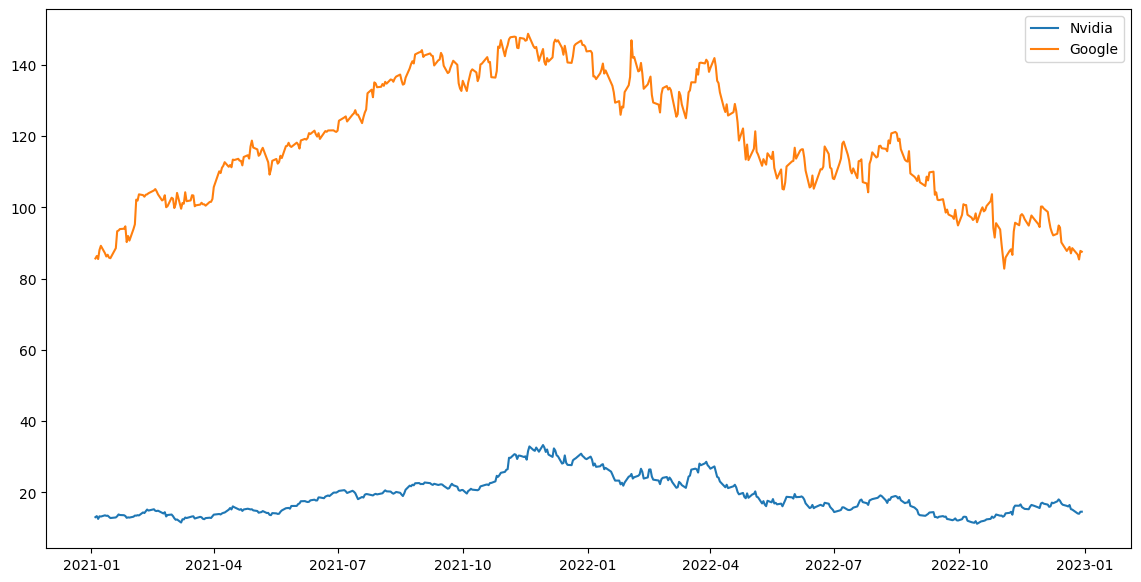

In [32]:
agent("⁠Generate a chart comparing Nvidia stock to Google. Save the graph as comparison.png file. Execute the code using code engine")

In [33]:
for message in agent.messages:
  print(message["content"])
  print("="*80)


Answer the following questions as best you can. You have access to the following tools:

Tool: code_generation_and_execution_tool
Description: a coding tool that can take a prompt and generate executable python code. it parses and executes the code. returns the code and the error if the code execution fails.
Arg: a single string parameter describing the coding task.


Tool: ares_internet_search_tool
Description: tool to search real-time relevant content from the internet
Arg: a single string parameter that will be searched on the internet to find relevant content


Tool: slide_generation_tool
Description: a tool that can create a pptx deck for a content. it takes a list of dictionaries. each list dictionary item represents a slide in the presentation. each dictionary item must have two keys: 'slide_title' and 'content'.
Arg: list[dict[slide_title, content]]. ensure the action input is json parseable so i can convert it to required format


Use the following format:

Question: the inpu